In [188]:
import os.path as osp
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from collections import defaultdict

In [189]:
pkg_dir = '/Users/ebronstein/Documents/spring2019/ee106b/labs/lab4/lab4_pkg/'

# Bend Sensor Calibration

In [200]:
def preprocess(df):
    mean_base_x = np.mean(df['base_pos_x'])
    mean_base_y = np.mean(df['base_pos_y'])
    # Get the tip displacement
    df['tip_disp_x'] = df['tip_pos_x'] - mean_base_x
    df['tip_disp_y'] = df['tip_pos_y'] - mean_base_y
    # bend angle = arctan(x/y)
    df['bend_angle'] = df.apply(lambda row: np.arctan2(row['tip_disp_x'], row['tip_disp_y']), axis=1)
    return df

def plot_bend(df, **kwargs):
    plt.scatter(df['time'], df['bend_angle'], **kwargs)
    plt.xlabel('time')
    plt.ylabel('bend angle')

def remove_transient(df):
    max_bend_angle = max(df['bend_angle'])
    min_bend_angle = min(df['bend_angle'])
    bend_angle_range = max_bend_angle - min_bend_angle
    cutoff = min_bend_angle + 0.97 * bend_angle_range
    return df[df['bend_angle'] >= cutoff]

## Preprocessing of bend sensor data
1) Read in each data file corresponding to a unique PWM value.

2) Remove the transient response from the data.

3) Plot the bend angle as a function of the resistance (right_flex).

4) Concatenate all of the data into one Dataframe.

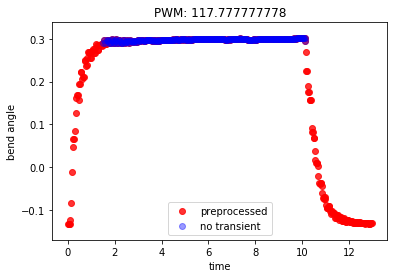

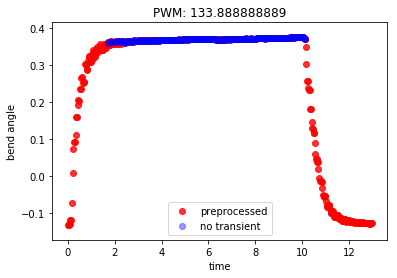

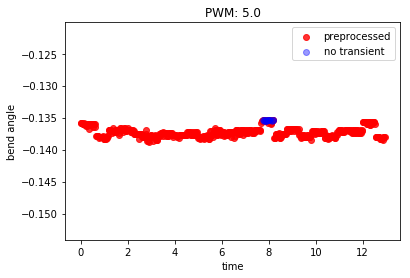

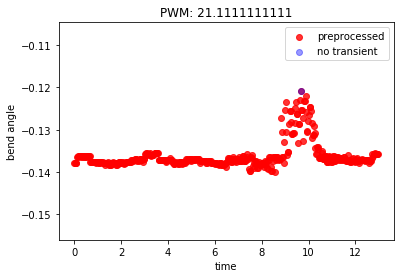

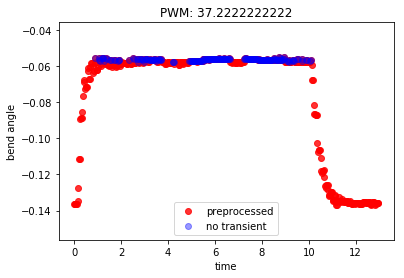

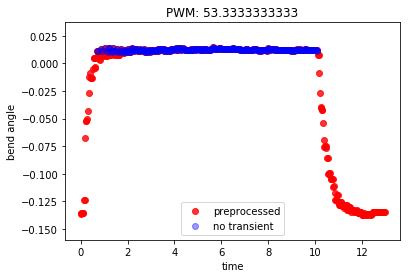

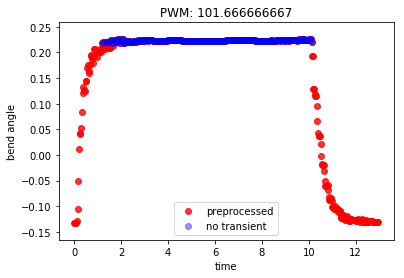

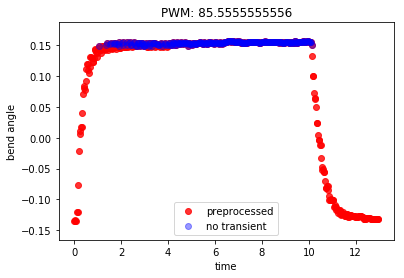

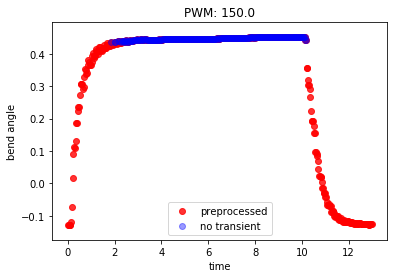

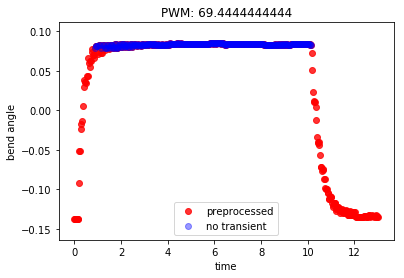

In [201]:
bend_folder = osp.join(pkg_dir, 'data/bend_calibration/')

data_list = []
for filename in os.listdir(bend_folder):
    if filename[-3:] == 'csv':
        full_filepath = osp.join(bend_folder, filename)
        this_df = preprocess(pd.read_csv(full_filepath))
        plot_bend(this_df, color='red', label='preprocessed', alpha=0.8)
        this_df = remove_transient(this_df)
        plot_bend(this_df, color='blue', label='no transient', alpha=0.4)
        pwm = filename[:-4].split('_')[0]
        plt.legend()
        plt.title('PWM: {0}'.format(pwm))
        plt.show()
        data_list.append(this_df)
        
df = pd.concat(data_list)

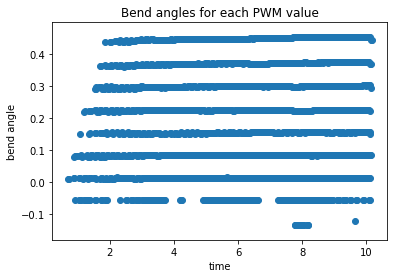

In [203]:
plot_bend(df)
plt.title('Bend angles for each PWM value')
plt.show()

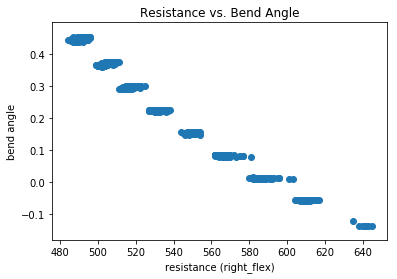

In [204]:
plt.scatter(df['right_flex'], df['bend_angle'])
plt.xlabel('resistance (right_flex)')
plt.ylabel('bend angle')
plt.title('Resistance vs. Bend Angle')
plt.show()

## Linear Regression
Use linear regression to fit a linear model of the bend angle as a function of the resistance to the data. Based on the shape of the data, we decided that the model $$\text{bend angle} = a \frac{1}{(\text{resistance})^2} + b$$ would best fit the data.

In [206]:
reg = LinearRegression()
X = (np.power(df['right_flex'].values, -2)).reshape((-1, 1))
y = (df['bend_angle'].values).reshape((-1, 1))
reg.fit(X, y)
score = reg.score(X, y)
print 'Score: {0}'.format(score)
print 'Coefficient (a): {0}'.format(reg.coef_[0][0])
print 'Intercept (b): {0}'.format(reg.intercept_[0])

Score: 0.994819614165
Coefficient (a): 349469.806112
Intercept (b): -1.00449021443


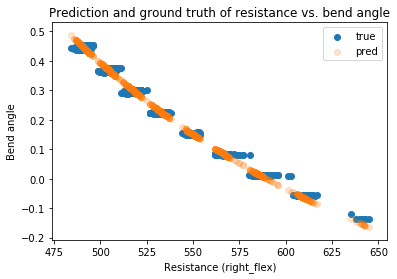

In [208]:
y_pred = reg.predict(X).flatten()
plt.scatter(df['right_flex'], df['bend_angle'], label='true')
plt.scatter(df['right_flex'], y_pred, label='pred', alpha=0.2)
plt.xlabel('Resistance (right_flex)')
plt.ylabel('Bend angle')
plt.title('Prediction and ground truth of resistance vs. bend angle')
plt.legend()
plt.show()

# System Identification

## Saving processed system ID data
Read in the system identification data, process it, and save it to CSVs in order to compute the $G$ matrix in MATLAB.

In [181]:
system_id_folder = osp.join(pkg_dir, 'data/system_id/')
processed_folder = osp.join(pkg_dir, 'data/processed_system_id')
datasets = defaultdict(list)
for filename in os.listdir(system_id_folder):
    stem, end = filename[:-4].split('_')
    datasets[stem].append(preprocess(pd.read_csv(osp.join(system_id_folder, filename))))
for dataset, df_list in datasets.items():
    # Save the unconcatenated dataframe
    for i, df in enumerate(df_list):
        df.to_csv(osp.join(processed_folder, '{0}_{1}.csv'.format(dataset, i))) 

    # Save the concatenated dataframe    
    df_concat  = pd.concat(df_list)
    df_concat = df_concat.drop('Unnamed: 0', axis=1)
    datasets[dataset] = df_concat
    # ds.to_csv(osp.join(processed_folder, str(dataset) + '.csv')) 

    

## Calculate G from q
Set up the linear regression to estimate $G$ from the bend angle $q$. If we only look at the steady-state response of the system once the transient response has died down, we have $\ddot{q}=0, \dot{q}=0, \ddot{\tau}=0, \dot{\tau}=0$. Plugging this into the dynamics, we get:

$$G+Kq=\alpha u$$

We get the bend angle from the data and compute the estimated bend angle $q$ from the resistance using the linear model from the previous section. We then compute $G$ using the MATLAB code for Lagrangian dynamics. Finally, we use linear regression to find estimates for $K$ and $\alpha$ by minimizing the loss $||G+Kq-\alpha u||_2^2$.

In [209]:
G_df_dict = {}

pwm_vals = ['5.0', '41.25', '77.5', '113.75', '150.0']
for pwm in pwm_vals:
    data_filepath = osp.join(pkg_dir, 'data/processed_system_id/', '{0}.csv'.format(pwm))
    df = pd.read_csv(data_filepath)
    q_G_filepath = osp.join(pkg_dir, 'data/G_from_q/', 'q_G_{0}.csv'.format(pwm))
    q_G_df = pd.read_csv(q_G_filepath, header=None)
    q_G_df.columns = ['estimated_bend_angle', 'G']

    G_df_dict[pwm] = pd.concat([df, q_G_df], axis=1).drop('Unnamed: 0', axis=1)

In [210]:
all_G_df = pd.concat(list(G_df_dict.values()))

In [211]:
X = all_G_df[['estimated_bend_angle', 'right_pwm']].values
X[:,0] *= -1 # negate estimated bend angle to match the dynamics in the static case
y = all_G_df['G'].values
reg = LinearRegression(fit_intercept=False)
reg.fit(X, y)
score = reg.score(X, y)
print 'Score: {0}'.format(score)
print 'Coefficients (K, alpha): {0}'.format(reg.coef_)
print 'Intercept: {0}'.format(reg.intercept_)

Score: 0.999983488267
Coefficients (K, alpha): [1.19551105e-02 8.44480534e-08]
Intercept: 0.0


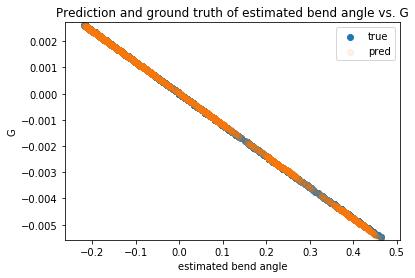

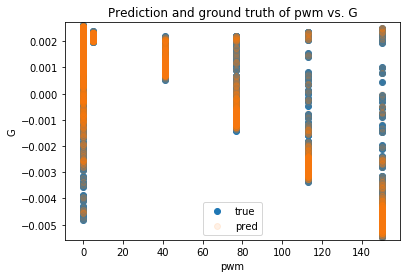

In [213]:
y_pred = reg.predict(X).flatten()
plt.scatter(all_G_df['estimated_bend_angle'], y, label='true')
plt.scatter(all_G_df['estimated_bend_angle'], y_pred, label='pred', alpha=0.1)
plt.ylim((min(y) - 0.0001, max(y) + 0.0001))
plt.legend()
plt.title('Prediction and ground truth of estimated bend angle vs. G')
plt.xlabel('estimated bend angle')
plt.ylabel('G')
plt.show()

plt.scatter(all_G_df['right_pwm'], y, label='true')
plt.scatter(all_G_df['right_pwm'], y_pred, label='pred', alpha=0.1)
plt.ylim((min(y) - 0.0001, max(y) + 0.0001))
plt.title('Prediction and ground truth of pwm vs. G')
plt.xlabel('pwm')
plt.ylabel('G')
plt.legend()
plt.show()